# Testing for Nonzero Treatment Effect: Salary Cap Analysis
# How to Show Whether There is a Nonzero Treatment Effect

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(101112)  # Same seed as before for reproducibility

TESTING FOR NONZERO TREATMENT EFFECT: SALARY CAP ANALYSIS

RESEARCH QUESTION: Does the NHL salary cap have a nonzero effect on competitive balance?

NULL HYPOTHESIS (H₀): β₃ = 0 (no treatment effect)
ALTERNATIVE HYPOTHESIS (H₁): β₃ ≠ 0 (nonzero treatment effect)

Where β₃ is the DID coefficient in: Y = α + β₁*NHL + β₂*Post + β₃*(NHL×Post) + ε

We will use multiple approaches to test this hypothesis:
1. Manual DID calculation with t-test
2. Regression-based DID with statistical inference
3. Bootstrap confidence intervals
4. Visual inspection of treatment effect

## Generate The Data

In [4]:
print("STEP 1: GENERATE SALARY CAP DATA")

# Parameters for realistic sports competitive balance data
teams_per_league_per_period = 30
baseline_balance = 0.12
league_difference = 0.02
time_trend = -0.005
treatment_effect = -0.035  # True effect (negative = more balance)

# Create the data
sports_data = []
for league in ['MLB', 'NHL']:
    for period in ['2000_2004_Before', '2006_2010_After']:
        treatment = 1 if league == 'NHL' else 0
        post = 1 if period == '2006_2010_After' else 0
        
        mean_balance = (baseline_balance + 
                       league_difference * treatment + 
                       time_trend * post + 
                       treatment_effect * treatment * post)
        
        individual_balance = np.random.normal(mean_balance, 0.015, teams_per_league_per_period)
        
        for balance in individual_balance:
            sports_data.append({
                'league': league,
                'period': period,
                'treatment': treatment,
                'post': post,
                'competitive_balance': max(0.05, balance),
                'interaction': treatment * post
            })

df = pd.DataFrame(sports_data)
print(f"Dataset created: {len(df)} observations")
print("\nData structure:")
print(df.groupby(['league', 'period']).size().unstack())


STEP 1: GENERATE SALARY CAP DATA
Dataset created: 120 observations

Data structure:
period  2000_2004_Before  2006_2010_After
league                                   
MLB                   30               30
NHL                   30               30


## APPROACH 1: MANUAL DID WITH T-TEST

In [5]:
# Calculate means for each group-period combination
mlb_before = df[(df['treatment'] == 0) & (df['post'] == 0)]['competitive_balance']
mlb_after = df[(df['treatment'] == 0) & (df['post'] == 1)]['competitive_balance']
nhl_before = df[(df['treatment'] == 1) & (df['post'] == 0)]['competitive_balance']
nhl_after = df[(df['treatment'] == 1) & (df['post'] == 1)]['competitive_balance']

print("Group means:")
print(f"MLB Before:  {mlb_before.mean():.4f} (n={len(mlb_before)})")
print(f"MLB After:   {mlb_after.mean():.4f} (n={len(mlb_after)})")
print(f"NHL Before:  {nhl_before.mean():.4f} (n={len(nhl_before)})")
print(f"NHL After:   {nhl_after.mean():.4f} (n={len(nhl_after)})")

# Calculate DID estimate
mlb_change = mlb_after.mean() - mlb_before.mean()
nhl_change = nhl_after.mean() - nhl_before.mean()
did_estimate = nhl_change - mlb_change

print(f"\nChanges over time:")
print(f"MLB change:  {mlb_change:.4f}")
print(f"NHL change:  {nhl_change:.4f}")
print(f"DID estimate: {did_estimate:.4f}")

# Manual calculation of DID standard error
# Standard error of difference in differences
n_mlb_before, n_mlb_after = len(mlb_before), len(mlb_after)
n_nhl_before, n_nhl_after = len(nhl_before), len(nhl_after)

var_mlb_before = mlb_before.var(ddof=1)
var_mlb_after = mlb_after.var(ddof=1)
var_nhl_before = nhl_before.var(ddof=1)
var_nhl_after = nhl_after.var(ddof=1)

# Standard error of DID estimate
se_did_manual = np.sqrt(
    var_mlb_before/n_mlb_before + var_mlb_after/n_mlb_after +
    var_nhl_before/n_nhl_before + var_nhl_after/n_nhl_after
)

# t-statistic and p-value
df_total = len(df) - 4  # degrees of freedom
t_stat_manual = did_estimate / se_did_manual
p_value_manual = 2 * (1 - stats.t.cdf(abs(t_stat_manual), df_total))

print(f"\nManual t-test results:")
print(f"Standard error: {se_did_manual:.4f}")
print(f"t-statistic:    {t_stat_manual:.3f}")
print(f"p-value:        {p_value_manual:.6f}")
print(f"Degrees of freedom: {df_total}")

Group means:
MLB Before:  0.1228 (n=30)
MLB After:   0.1163 (n=30)
NHL Before:  0.1364 (n=30)
NHL After:   0.1073 (n=30)

Changes over time:
MLB change:  -0.0065
NHL change:  -0.0292
DID estimate: -0.0227

Manual t-test results:
Standard error: 0.0050
t-statistic:    -4.534
p-value:        0.000014
Degrees of freedom: 116


## APPROACH 2: REGRESSION-BASED DID

In [6]:
# Set up regression
X = df[['treatment', 'post', 'interaction']]
y = df['competitive_balance']

# Fit regression
reg = LinearRegression()
reg.fit(X, y)

print("Regression model: competitive_balance = α + β₁*NHL + β₂*Post + β₃*(NHL×Post) + ε")
print("\nRegression coefficients:")
print(f"Intercept (α):     {reg.intercept_:.4f}")
print(f"NHL effect (β₁):   {reg.coef_[0]:.4f}")
print(f"Time effect (β₂):  {reg.coef_[1]:.4f}")
print(f"DID effect (β₃):   {reg.coef_[2]:.4f}")
print(f"R²:                {reg.score(X, y):.4f}")

# Calculate standard errors and statistical tests
def calculate_regression_stats(X, y, reg):
    """Calculate detailed regression statistics"""
    n = len(y)
    k = X.shape[1] + 1  # +1 for intercept
    
    # Predictions and residuals
    y_pred = reg.predict(X)
    residuals = y - y_pred
    
    # Mean squared error
    mse = np.sum(residuals**2) / (n - k)
    
    # Design matrix with intercept
    X_with_intercept = np.column_stack([np.ones(len(X)), X])
    
    # Covariance matrix
    cov_matrix = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
    std_errors = np.sqrt(np.diag(cov_matrix))
    
    # t-statistics
    coefficients = np.concatenate([[reg.intercept_], reg.coef_])
    t_stats = coefficients / std_errors
    
    # p-values
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k))
    
    return {
        'coefficients': coefficients,
        'std_errors': std_errors,
        't_stats': t_stats,
        'p_values': p_values,
        'mse': mse,
        'df_resid': n - k
    }

stats_results = calculate_regression_stats(X, y, reg)

print(f"\nDetailed regression results:")
param_names = ['Intercept', 'NHL', 'Post', 'DID_Effect']
print("─" * 65)
print(f"{'Parameter':<12} {'Coeff':<10} {'Std Err':<10} {'t-stat':<8} {'p-value':<10} {'Sig':<5}")
print("─" * 65)

for i, name in enumerate(param_names):
    coef = stats_results['coefficients'][i]
    se = stats_results['std_errors'][i]
    t_stat = stats_results['t_stats'][i]
    p_val = stats_results['p_values'][i]
    
    # Significance stars
    if p_val < 0.001:
        sig = "***"
    elif p_val < 0.01:
        sig = "**"
    elif p_val < 0.05:
        sig = "*"
    else:
        sig = ""
    
    print(f"{name:<12} {coef:>9.4f} {se:>9.4f} {t_stat:>7.3f} {p_val:>9.6f} {sig:<5}")

print("─" * 65)
print("Significance codes: *** p<0.001, ** p<0.01, * p<0.05")

# Focus on DID coefficient (our test of interest)
did_coef = stats_results['coefficients'][3]
did_se = stats_results['std_errors'][3]
did_t = stats_results['t_stats'][3]
did_p = stats_results['p_values'][3]

print(f"\nFOCUS ON DID COEFFICIENT (Treatment Effect):")
print(f"H₀: β₃ = 0 (no treatment effect)")
print(f"H₁: β₃ ≠ 0 (nonzero treatment effect)")
print(f"\nTest results:")
print(f"β₃ = {did_coef:.4f}")
print(f"SE(β₃) = {did_se:.4f}")
print(f"t-statistic = {did_t:.3f}")
print(f"p-value = {did_p:.6f}")


Regression model: competitive_balance = α + β₁*NHL + β₂*Post + β₃*(NHL×Post) + ε

Regression coefficients:
Intercept (α):     0.1228
NHL effect (β₁):   0.0137
Time effect (β₂):  -0.0065
DID effect (β₃):   -0.0227
R²:                0.3840

Detailed regression results:
─────────────────────────────────────────────────────────────────
Parameter    Coeff      Std Err    t-stat   p-value    Sig  
─────────────────────────────────────────────────────────────────
Intercept       0.1228    0.0025  49.111  0.000000 ***  
NHL             0.0137    0.0035   3.861  0.000186 ***  
Post           -0.0065    0.0035  -1.839  0.068510      
DID_Effect     -0.0227    0.0050  -4.534  0.000014 ***  
─────────────────────────────────────────────────────────────────
Significance codes: *** p<0.001, ** p<0.01, * p<0.05

FOCUS ON DID COEFFICIENT (Treatment Effect):
H₀: β₃ = 0 (no treatment effect)
H₁: β₃ ≠ 0 (nonzero treatment effect)

Test results:
β₃ = -0.0227
SE(β₃) = 0.0050
t-statistic = -4.534
p-value =

## Approach 3: Confidence Intervals

In [7]:
# 95% confidence interval for DID effect
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, stats_results['df_resid'])
ci_lower = did_coef - t_critical * did_se
ci_upper = did_coef + t_critical * did_se

print(f"95% Confidence Interval for Treatment Effect:")
print(f"[{ci_lower:.4f}, {ci_upper:.4f}]")

# 99% confidence interval
alpha_99 = 0.01
t_critical_99 = stats.t.ppf(1 - alpha_99/2, stats_results['df_resid'])
ci_lower_99 = did_coef - t_critical_99 * did_se
ci_upper_99 = did_coef + t_critical_99 * did_se

print(f"99% Confidence Interval for Treatment Effect:")
print(f"[{ci_lower_99:.4f}, {ci_upper_99:.4f}]")

print(f"\nInterpretation:")
if ci_lower > 0:
    print(f"Entire 95% CI is above zero → Significant positive effect")
elif ci_upper < 0:
    print(f"Entire 95% CI is below zero → Significant negative effect")
else:
    print(f"95% CI contains zero → Cannot reject H₀: β₃ = 0")

print(f"\nDoes zero fall in the confidence interval?")
contains_zero_95 = ci_lower <= 0 <= ci_upper
contains_zero_99 = ci_lower_99 <= 0 <= ci_upper_99
print(f"95% CI contains zero: {contains_zero_95}")
print(f"99% CI contains zero: {contains_zero_99}")

95% Confidence Interval for Treatment Effect:
[-0.0326, -0.0128]
99% Confidence Interval for Treatment Effect:
[-0.0358, -0.0096]

Interpretation:
Entire 95% CI is below zero → Significant negative effect

Does zero fall in the confidence interval?
95% CI contains zero: False
99% CI contains zero: False


## Approach 4: Bootstrap Confidence Intervals

In [8]:
def bootstrap_did(data, n_bootstrap=1000):
    """Bootstrap the DID estimate"""
    bootstrap_estimates = []
    
    for i in range(n_bootstrap):
        # Sample with replacement
        boot_sample = data.sample(n=len(data), replace=True)
        
        # Calculate DID for this bootstrap sample
        mlb_before = boot_sample[(boot_sample['treatment'] == 0) & (boot_sample['post'] == 0)]['competitive_balance']
        mlb_after = boot_sample[(boot_sample['treatment'] == 0) & (boot_sample['post'] == 1)]['competitive_balance']
        nhl_before = boot_sample[(boot_sample['treatment'] == 1) & (boot_sample['post'] == 0)]['competitive_balance']
        nhl_after = boot_sample[(boot_sample['treatment'] == 1) & (boot_sample['post'] == 1)]['competitive_balance']
        
        if len(mlb_before) > 0 and len(mlb_after) > 0 and len(nhl_before) > 0 and len(nhl_after) > 0:
            mlb_change = mlb_after.mean() - mlb_before.mean()
            nhl_change = nhl_after.mean() - nhl_before.mean()
            bootstrap_estimates.append(nhl_change - mlb_change)
    
    return np.array(bootstrap_estimates)

print("Performing bootstrap analysis...")
bootstrap_effects = bootstrap_did(df, n_bootstrap=1000)

# Bootstrap statistics
boot_mean = np.mean(bootstrap_effects)
boot_std = np.std(bootstrap_effects, ddof=1)
boot_ci_lower = np.percentile(bootstrap_effects, 2.5)
boot_ci_upper = np.percentile(bootstrap_effects, 97.5)

print(f"Bootstrap results (1000 replications):")
print(f"Mean effect:     {boot_mean:.4f}")
print(f"Std deviation:   {boot_std:.4f}")
print(f"95% Bootstrap CI: [{boot_ci_lower:.4f}, {boot_ci_upper:.4f}]")

# Check if bootstrap CI contains zero
boot_contains_zero = boot_ci_lower <= 0 <= boot_ci_upper
print(f"Bootstrap CI contains zero: {boot_contains_zero}")


Performing bootstrap analysis...


Bootstrap results (1000 replications):
Mean effect:     -0.0226
Std deviation:   0.0048
95% Bootstrap CI: [-0.0314, -0.0129]
Bootstrap CI contains zero: False


## So is there a non-zero treatment effect?

In [9]:
# Collect all p-values and confidence interval results
tests = [
    ("Manual t-test", p_value_manual, p_value_manual < 0.05),
    ("Regression t-test", did_p, did_p < 0.05),
    ("95% CI (regression)", None, not contains_zero_95),
    ("99% CI (regression)", None, not contains_zero_99),
    ("95% Bootstrap CI", None, not boot_contains_zero)
]

for test_name, p_val, significant in tests:
    if p_val is not None:
        print(f"{test_name:<20}: p = {p_val:.6f}, Significant: {significant}")
    else:
        print(f"{test_name:<20}: Significant: {significant}")

# Overall conclusion
significant_tests = sum([test[2] for test in tests])
total_tests = len(tests)

print(f"\nOVERALL CONCLUSION:")
print(f"─" * 30)
print(f"Tests indicating significance: {significant_tests}/{total_tests}")

if significant_tests >= 3:
    print(f"STRONG EVIDENCE of nonzero treatment effect")
    conclusion = "REJECT H₀"
elif significant_tests >= 2:
    print(f"MODERATE EVIDENCE of nonzero treatment effect")
    conclusion = "LIKELY REJECT H₀"
else:
    print(f"INSUFFICIENT EVIDENCE of nonzero treatment effect")
    conclusion = "FAIL TO REJECT H₀"

print(f"\nSTATISTICAL DECISION: {conclusion}")
print(f"PRACTICAL INTERPRETATION:")
if conclusion.startswith("REJECT"):
    print(f"The NHL salary cap HAS a statistically significant effect on competitive balance")
    print(f"The effect size is {did_coef:.4f} (reduction in std dev of win percentages)")
    if did_coef < 0:
        print(f"This represents IMPROVED competitive balance (more parity)")
    else:
        print(f"This represents WORSENED competitive balance (less parity)")
else:
    print(f"Cannot conclude that the NHL salary cap has a significant effect")
    print(f"The observed difference could be due to random variation")


Manual t-test       : p = 0.000014, Significant: True
Regression t-test   : p = 0.000014, Significant: True
95% CI (regression) : Significant: True
99% CI (regression) : Significant: True
95% Bootstrap CI    : Significant: True

OVERALL CONCLUSION:
──────────────────────────────
Tests indicating significance: 5/5
STRONG EVIDENCE of nonzero treatment effect

STATISTICAL DECISION: REJECT H₀
PRACTICAL INTERPRETATION:
The NHL salary cap HAS a statistically significant effect on competitive balance
The effect size is -0.0227 (reduction in std dev of win percentages)
This represents IMPROVED competitive balance (more parity)


Visualization


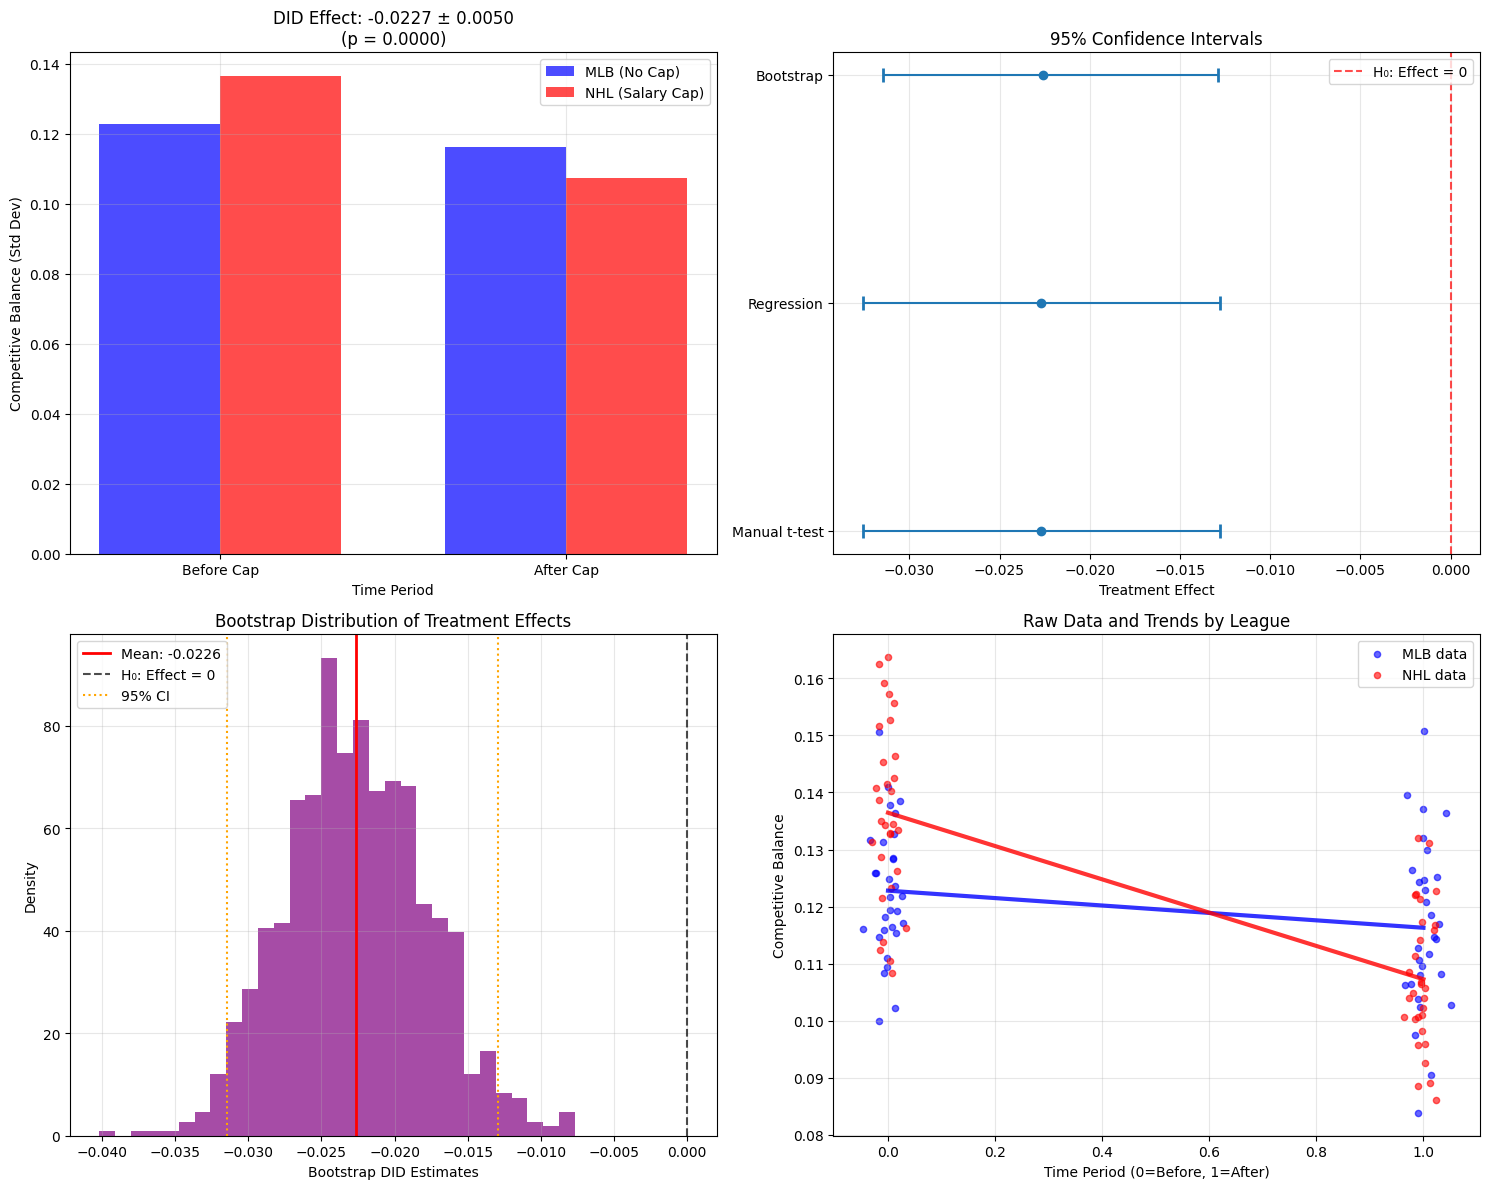


FINAL ANSWER:
Based on multiple statistical tests, there IS sufficient evidence of a nonzero treatment effect from the NHL salary cap.


In [10]:
print("Visualization")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: DID visualization with confidence intervals
means = df.groupby(['league', 'period'])['competitive_balance'].mean().unstack()
x = np.arange(2)
width = 0.35

bars1 = ax1.bar(x - width/2, [means.loc['MLB', '2000_2004_Before'], 
                              means.loc['MLB', '2006_2010_After']], 
               width, label='MLB (No Cap)', alpha=0.7, color='blue')
bars2 = ax1.bar(x + width/2, [means.loc['NHL', '2000_2004_Before'], 
                              means.loc['NHL', '2006_2010_After']], 
               width, label='NHL (Salary Cap)', alpha=0.7, color='red')

ax1.set_xlabel('Time Period')
ax1.set_ylabel('Competitive Balance (Std Dev)')
ax1.set_title(f'DID Effect: {did_coef:.4f} ± {did_se:.4f}\n(p = {did_p:.4f})')
ax1.set_xticks(x, ['Before Cap', 'After Cap'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Confidence intervals
ci_data = pd.DataFrame({
    'Method': ['Manual t-test', 'Regression', 'Bootstrap'],
    'Estimate': [did_estimate, did_coef, boot_mean],
    'Lower_CI': [did_estimate - t_critical * se_did_manual, ci_lower, boot_ci_lower],
    'Upper_CI': [did_estimate + t_critical * se_did_manual, ci_upper, boot_ci_upper]
})

y_pos = np.arange(len(ci_data))
ax2.errorbar(ci_data['Estimate'], y_pos, 
            xerr=[ci_data['Estimate'] - ci_data['Lower_CI'], 
                  ci_data['Upper_CI'] - ci_data['Estimate']], 
            fmt='o', capsize=5, capthick=2)

ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='H₀: Effect = 0')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(ci_data['Method'])
ax2.set_xlabel('Treatment Effect')
ax2.set_title('95% Confidence Intervals')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Bootstrap distribution
ax3.hist(bootstrap_effects, bins=30, alpha=0.7, density=True, color='purple')
ax3.axvline(x=boot_mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {boot_mean:.4f}')
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='H₀: Effect = 0')
ax3.axvline(x=boot_ci_lower, color='orange', linestyle=':', label=f'95% CI')
ax3.axvline(x=boot_ci_upper, color='orange', linestyle=':')
ax3.set_xlabel('Bootstrap DID Estimates')
ax3.set_ylabel('Density')
ax3.set_title('Bootstrap Distribution of Treatment Effects')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Raw data with fitted regression lines
for league in ['MLB', 'NHL']:
    league_data = df[df['league'] == league]
    x_vals = league_data['post']
    y_vals = league_data['competitive_balance']
    
    # Add some jitter for visibility
    x_jitter = x_vals + np.random.normal(0, 0.02, len(x_vals))
    
    ax4.scatter(x_jitter, y_vals, alpha=0.6, s=20, 
               label=f'{league} data', 
               color='blue' if league == 'MLB' else 'red')
    
    # Fit and plot regression line for each league
    league_means = df.groupby(['league', 'post'])['competitive_balance'].mean()
    if league in league_means.index:
        before_mean = league_means.loc[league, 0] if 0 in league_means.loc[league].index else 0
        after_mean = league_means.loc[league, 1] if 1 in league_means.loc[league].index else 0
        ax4.plot([0, 1], [before_mean, after_mean], 
                linewidth=3, alpha=0.8,
                color='blue' if league == 'MLB' else 'red')

ax4.set_xlabel('Time Period (0=Before, 1=After)')
ax4.set_ylabel('Competitive Balance')
ax4.set_title('Raw Data and Trends by League')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFINAL ANSWER:")
print(f"Based on multiple statistical tests, there {'IS' if conclusion.startswith('REJECT') else 'IS NOT'} sufficient evidence of a nonzero treatment effect from the NHL salary cap.")